In [1]:
# import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# import facebook prophet
from fbprophet import Prophet

# import keras
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential

# import sklearn metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# import utilities
import pickle
import requests
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

# display preferences
%matplotlib inline
plt.style.use('fivethirtyeight')
register_matplotlib_converters()

### EDA and Data Cleaning

In [2]:
url = 'https://api.covidtracking.com/v1/us/daily.json'
response = requests.get(url)
d = response.json()
df = pd.DataFrame(d)
df['date'] = pd.to_datetime(df.date, format='%Y%m%d')
df.set_index('date', inplace=True)
df = df[::-1] #<--- reverse chronology
# df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq) #<--- set freq.

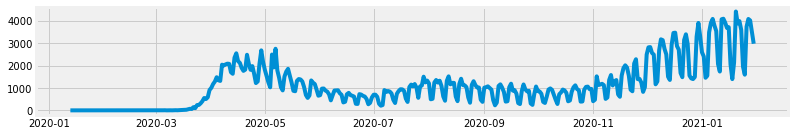

In [3]:
# construct seperate dataframes per target variable
deaths = pd.DataFrame(df.deathIncrease, index=df.index)

# drop nan values from the start of each target dataframe
deaths.dropna(inplace=True)

# add one to all values of zero for log transforms
deaths['deathIncrease'] = np.where(deaths.deathIncrease == 0, 1, deaths.deathIncrease)

# plot target variables
plt.figure(figsize=(12,2))
plt.plot(deaths)
plt.show()

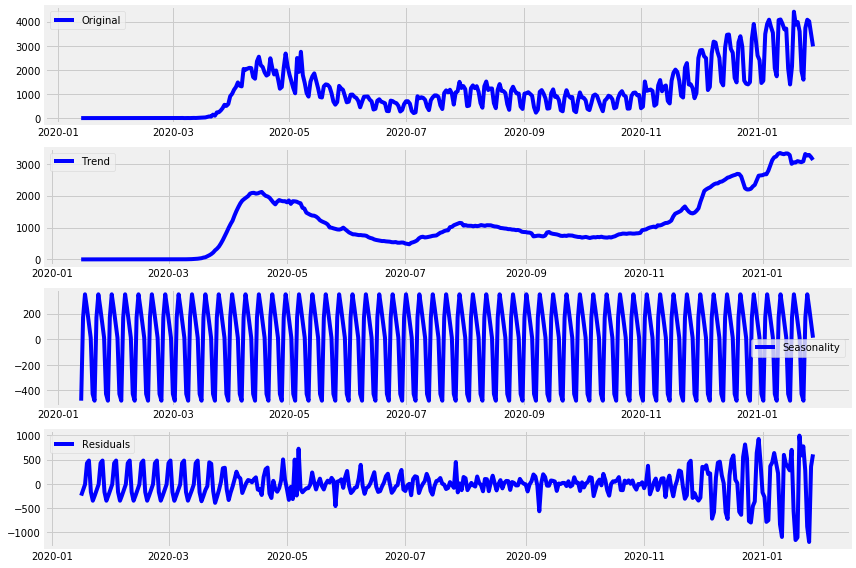

In [4]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(deaths)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(deaths, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

Check stationarity

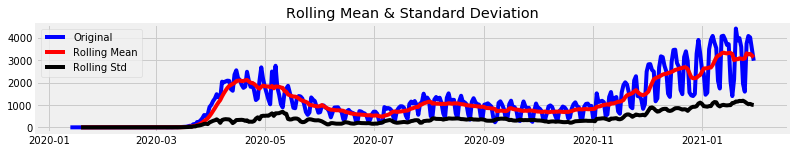

Results of Dickey-Fuller Test: 

Test Statistic                  -1.384700
p-value                          0.589589
#Lags Used                      14.000000
Number of Observations Used    369.000000
Critical Value (1%)             -3.448197
Critical Value (5%)             -2.869405
Critical Value (10%)            -2.570960
dtype: float64


In [5]:
# Calculate rolling statistics
roll_mean = deaths.rolling(window=7, center=False).mean()
roll_std = deaths.rolling(window=7, center=False).std()

# Perform the Dickey Fuller test
dftest = adfuller(deaths) 

# Plot rolling statistics:
fig = plt.figure(figsize=(12,2))
orig = plt.plot(deaths, color='blue',label='Original')
mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
std = plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Print Dickey-Fuller test results
print('Results of Dickey-Fuller Test: \n')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                         '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

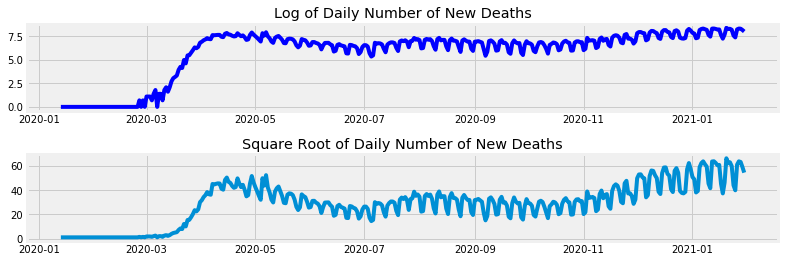

Log of Deaths:
Test Statistic                  -3.199426
p-value                          0.020018
#Lags Used                      16.000000
Number of Observations Used    367.000000
Critical Value (1%)             -3.448294
Critical Value (5%)             -2.869448
Critical Value (10%)            -2.570983
dtype: float64

Square Root of Deaths
Test Statistic                  -2.053982
p-value                          0.263417
#Lags Used                      14.000000
Number of Observations Used    369.000000
Critical Value (1%)             -3.448197
Critical Value (5%)             -2.869405
Critical Value (10%)            -2.570960
dtype: float64


In [6]:
# plot a log and square root transform
fig, axs = plt.subplots(2, 1, figsize=(12,4))
axs[0].plot(np.log(deaths), color='blue');
axs[0].set_title('Log of Daily Number of New Deaths')
axs[1].plot(np.sqrt(deaths))
axs[1].set_title('Square Root of Daily Number of New Deaths')
plt.subplots_adjust(hspace = 0.5)
plt.show()

# Perform the Dickey Fuller test
print('Log of Deaths:')
dftest = adfuller(np.log(deaths)) 

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                         '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

# Perform the Dickey Fuller test
print('\nSquare Root of Deaths')
dftest = adfuller(np.sqrt(deaths)) 

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                         '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

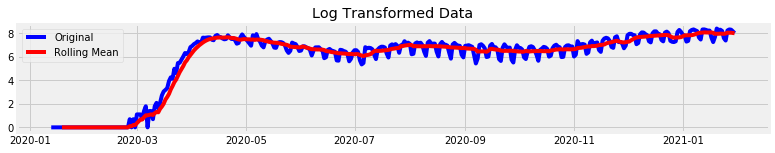

In [7]:
# Visualize log transformed data 
deaths_roll_mean = np.log(deaths).rolling(window=7).mean()
fig = plt.figure(figsize=(12,2))
plt.plot(np.log(deaths), color='blue', label='Original')
plt.plot(deaths_roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Log Transformed Data')
plt.show(block=False)

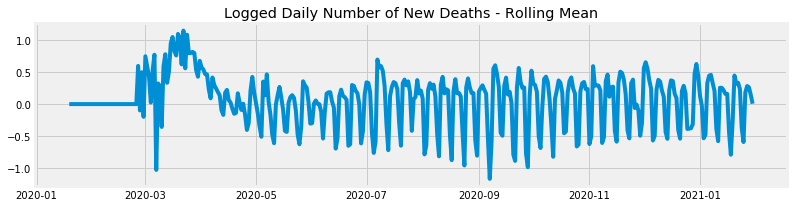

In [8]:
# Subtract the moving average from the log transformed data
deaths_data_minus_roll_mean = np.log(deaths) - deaths_roll_mean

# Drop the missing values
deaths_data_minus_roll_mean.dropna(inplace=True)

# replot target variables
plt.figure(figsize=(12,3))
plt.plot(deaths_data_minus_roll_mean)
plt.title('Logged Daily Number of New Deaths - Rolling Mean')
plt.show()

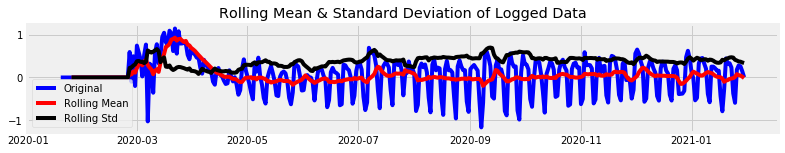

Results of Dickey-Fuller Test: 

Test Statistic                  -2.873241
p-value                          0.048549
#Lags Used                      16.000000
Number of Observations Used    361.000000
Critical Value (1%)             -3.448595
Critical Value (5%)             -2.869580
Critical Value (10%)            -2.571053
dtype: float64


In [9]:
# Calculate rolling statistics
roll_mean = deaths_data_minus_roll_mean.rolling(window=7, center=False).mean()
roll_std = deaths_data_minus_roll_mean.rolling(window=7, center=False).std()

# Perform the Dickey Fuller test
dftest = adfuller(deaths_data_minus_roll_mean) 

# Plot rolling statistics:
fig = plt.figure(figsize=(12,2))
orig = plt.plot(deaths_data_minus_roll_mean, color='blue',label='Original')
mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
std = plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation of Logged Data')
plt.show(block=False)

# Print Dickey-Fuller test results
print('Results of Dickey-Fuller Test: \n')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                         '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

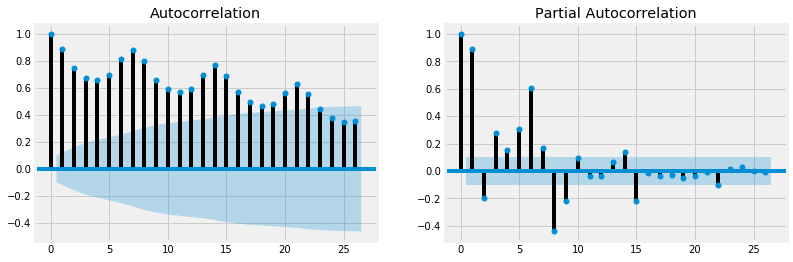

In [10]:
# Plot deaths ACF & PACF
fig, axs = plt.subplots(1, 2, figsize=(12,4))
plot_acf(deaths, ax=axs[0]);
plot_pacf(deaths, ax=axs[1]);
plt.subplots_adjust(hspace = 0.5)
plt.show()

### Modeling

#### SARIMAX Grid Search

In [11]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(1, 2)
d = range(1, 2)
q = range(1, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

p = range(0, 2)
d = range(0, 2)
q = range(0, 3)

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [12]:
"""UNCOMMENT CELL BELOW TO RUN GRID SEARCH"""

'UNCOMMENT CELL BELOW TO RUN GRID SEARCH'

In [13]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(deaths,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}7 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

# pickle grid parameters
pickle_out = open("death_grid.pickle","wb")
pickle.dump(ans_df, pickle_out)
pickle_out.close()

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 0, 0, 7)7 : AIC Calculated =5746.266173965792


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 7)7 : AIC Calculated =5458.786417097692


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 0, 2, 7)7 : AIC Calculated =5268.744129411599
ARIMA (1, 1, 1) x (0, 1, 0, 7)7 : AIC Calculated =5318.347478084827


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 7)7 : AIC Calculated =5121.7412021643895


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 2, 7)7 : AIC Calculated =5033.122778617704


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 0, 0, 7)7 : AIC Calculated =5302.963161979831


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages

ARIMA (1, 1, 1) x (1, 0, 1, 7)7 : AIC Calculated =5219.015666401652
ARIMA (1, 1, 1) x (1, 0, 2, 7)7 : AIC Calculated =5117.656980056081


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 0, 7)7 : AIC Calculated =5158.500451258868


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 1, 7)7 : AIC Calculated =5123.740584658573


/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 2, 7)7 : AIC Calculated =5033.706429096788


In [14]:
# load grid parameters
ans_df = pd.read_pickle('death_grid.pickle')

#### SARIMAX Model

In [15]:
# Check grid search results
ans_df.loc[ans_df['aic'].idxmin()][0], ans_df.loc[ans_df['aic'].idxmin()][1]

((1, 1, 1), (0, 1, 2, 7))

In [16]:
ARIMA_MODEL = SARIMAX(endog=np.log(deaths),
                      order=ans_df.loc[ans_df['aic'].idxmin()][0],
                      seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1],
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0862      0.082     -1.050      0.294      -0.247       0.075
ma.L1         -0.3789      0.076     -4.968      0.000      -0.528      -0.229
ma.S.L7       -0.6229      0.034    -18.306      0.000      -0.690      -0.556
ma.S.L14      -0.0834      0.041     -2.050      0.040      -0.163      -0.004
sigma2         0.0659      0.003     20.059      0.000       0.059       0.072


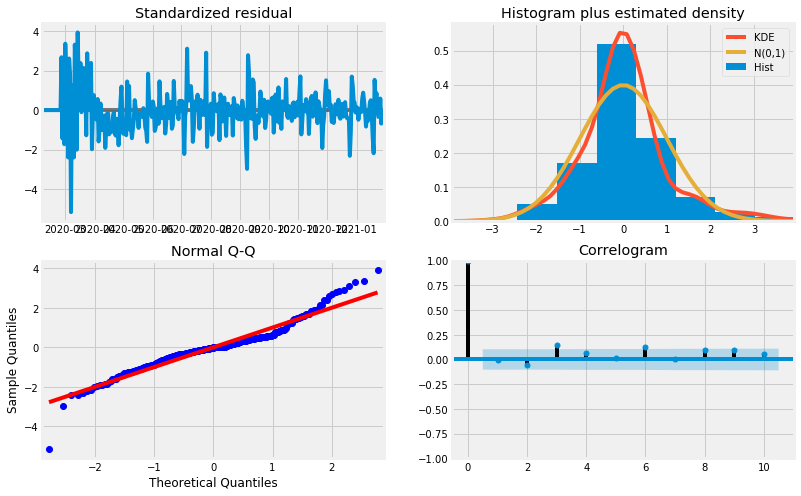

In [17]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(12, 8))
plt.show()

In [18]:
# Get predictions starting from past 60 days and calculate confidence intervals
pred = output.get_prediction(start=deaths.index[-60], dynamic=False)
pred_conf = pred.conf_int()

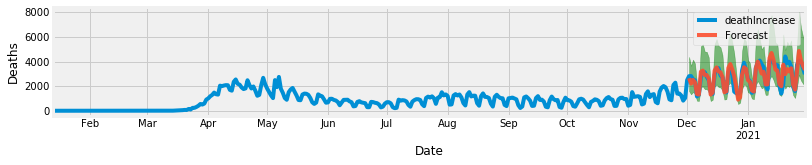

In [19]:
# Plot real vs predicted values along with confidence interval

plt.rcParams['figure.figsize'] = 12, 2

# Plot observed values
ax = deaths.plot(label='observed')

# Plot predicted values
np.exp(pred.predicted_mean).plot(ax=ax, label='Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                np.exp(pred_conf).iloc[:, 0],
                np.exp(pred_conf).iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
plt.legend()

plt.show()

In [20]:
# Get the real and predicted values
deaths_forecasted = np.exp(pred.predicted_mean)
deaths_truth = deaths[-60:]

# Compute the mean square error
mse = ((deaths_forecasted - deaths_truth.deathIncrease) ** 2).mean()
rmse = np.sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 217982.77
The Root Mean Squared Error of our forecasts is 466.89


In [21]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=deaths.index[-30], dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int(alpha=0.1)

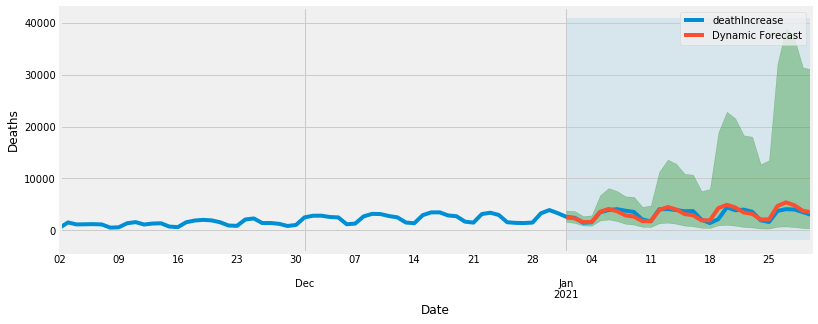

In [22]:
# Plot the dynamic forecast with confidence intervals.

ax = deaths.plot(label='observed', figsize=(12, 4.5))
np.exp(pred_dynamic.predicted_mean).plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                np.exp(pred_dynamic_conf.iloc[:, 0]),
                np.exp(pred_dynamic_conf.iloc[:, 1]), color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), deaths.index[-30], deaths_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
ax.set_xlim(left=deaths.index[-90], right=deaths.index[-1])

plt.legend()
plt.show()

In [23]:
# Extract the predicted and true values of our time series
deaths_forecasted = np.exp(pred_dynamic.predicted_mean)

# Compute the mean square error
mse = ((deaths_forecasted - deaths.deathIncrease[-30:]) ** 2).mean()
rmse = np.sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 432067.17
The Root Mean Squared Error of our forecasts is 657.32


In [24]:
# Get forecast 14 days ahead in future
prediction = output.get_forecast(steps=14)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha=.1)

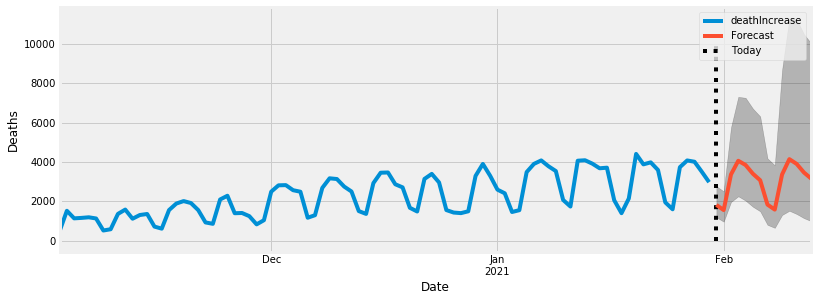

In [25]:
# Plot future predictions with confidence intervals
ax = deaths.plot(label='observed', figsize=(12, 4.5))
np.exp(prediction.predicted_mean).plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                np.exp(pred_conf.iloc[:, 0]),
                np.exp(pred_conf.iloc[:, 1]), color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
ax.set_xlim(left=deaths.index[-90], right=deaths.index[-1]+pd.DateOffset(14))
plt.vlines(x=deaths.index[-1]+pd.DateOffset(1), ymin=0, ymax=10000, linestyles='dotted', label='Today')
plt.legend()
plt.show()

#### Facebook Prophet Model

In [26]:
fb_death = pd.DataFrame()
fb_death['y'] = df.deathIncrease
fb_death.reset_index(inplace=True)

In [27]:
fb_death.rename(columns={'date':'ds'}, inplace=True)

In [28]:
death_train_fb, death_test_fb = fb_death[:-100], fb_death[-100:]

In [29]:
model_death = Prophet(interval_width=0.95)
model_death.fit(death_train_fb)

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
future_dates = model_death.make_future_dataframe(periods=100, freq='D')
forecast_death = model_death.predict(future_dates)
forecast_death.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-13,-250.461677,-1386.499516,300.436035,-250.461677,-250.461677,-288.201760,-288.201760,-288.201760,-288.201760,-288.201760,-288.201760,0.0,0.0,0.0,-538.663437
1,2020-01-14,-236.825908,-954.728606,685.000271,-236.825908,-236.825908,99.496693,99.496693,99.496693,99.496693,99.496693,99.496693,0.0,0.0,0.0,-137.329215
2,2020-01-15,-223.190139,-842.330114,841.874368,-223.190139,-223.190139,204.272402,204.272402,204.272402,204.272402,204.272402,204.272402,0.0,0.0,0.0,-18.917738
3,2020-01-16,-209.554370,-926.275118,781.465711,-209.554370,-209.554370,158.945616,158.945616,158.945616,158.945616,158.945616,158.945616,0.0,0.0,0.0,-50.608755
4,2020-01-17,-195.918602,-920.218149,694.690527,-195.918602,-195.918602,98.900208,98.900208,98.900208,98.900208,98.900208,98.900208,0.0,0.0,0.0,-97.018394


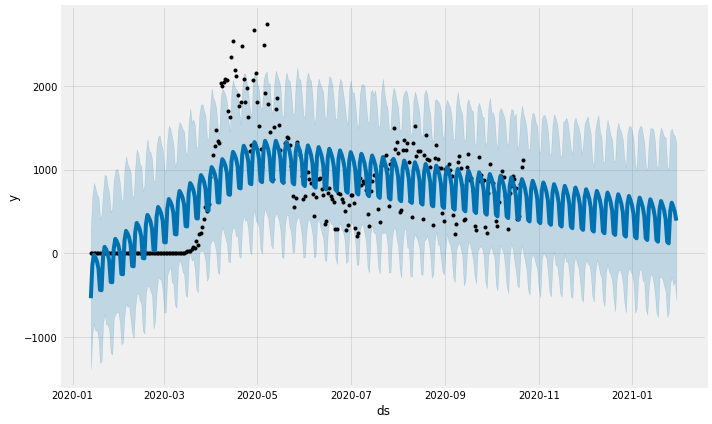

In [31]:
model_death.plot(forecast_death, uncertainty=True);

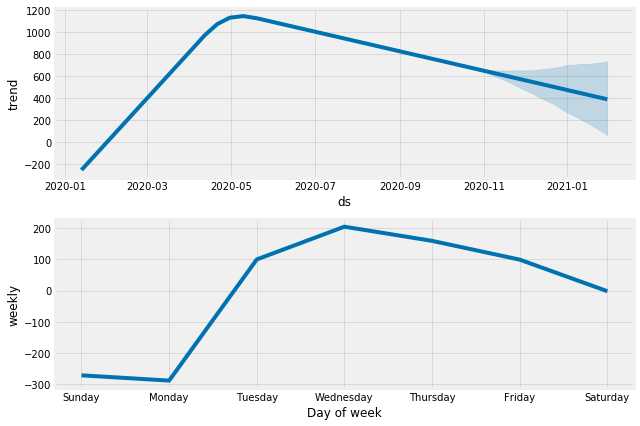

In [32]:
model_death.plot_components(forecast_death);

In [33]:
fb_positive = pd.DataFrame()
fb_positive['y'] = df.positiveIncrease
fb_positive.reset_index(inplace=True)

In [34]:
fb_positive.rename(columns={'date':'ds'}, inplace=True)

In [35]:
positive_train_fb, positive_test_fb = fb_positive[:-100], fb_positive[-100:]

In [36]:
model_positive = Prophet(interval_width=0.95)
model_positive.fit(positive_train_fb)

forecast_positive = model_positive.predict(future_dates)

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Long Short-Term Memory Model

In [37]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [38]:
df_lstm = pd.DataFrame()
df_lstm['death'] = df.deathIncrease

In [39]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_lstm)

In [40]:
train, test = dataset[:-100], dataset[-100:]

In [41]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [42]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [43]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [44]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

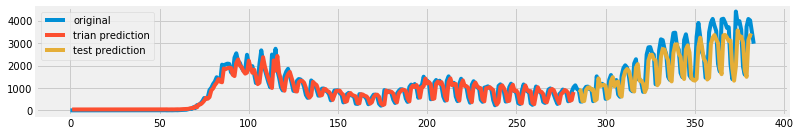

In [45]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='original')
plt.plot(trainPredictPlot,label='trian prediction')
plt.plot(testPredictPlot,label='test prediction')
plt.legend()

### Model Evaluation

#### SARIMAX Model Evaluation

In [46]:
# calculate root mean squared error
train_rmse_death_smx = mean_squared_error(np.exp(pred.predicted_mean), deaths.deathIncrease[-60:], squared=False)
train_mae_death_smx = mean_absolute_error(np.exp(pred.predicted_mean), deaths.deathIncrease[-60:])

# calculate mean absolute error
test_rmse_death_smx = mean_squared_error(deaths_forecasted[-30:], deaths.deathIncrease[-30:], squared=False)
test_mae_death_smx = mean_absolute_error(deaths_forecasted[-30:], deaths.deathIncrease[-30:])

print('The Training Root Mean Squared Error of our forecasts is {}'.format(round(train_rmse_death_smx, 2)))
print('The Testing Root Mean Squared Error of our forecasts is {}'.format(round(test_rmse_death_smx, 2)))
print('The Training Mean Absolute Error of our forecasts is {}'.format(round(train_mae_death_smx, 2)))
print('The Testing Mean Absolute Error of our forecasts is {}'.format(round(test_mae_death_smx, 2)))

The Training Root Mean Squared Error of our forecasts is 466.89
The Testing Root Mean Squared Error of our forecasts is 657.32
The Training Mean Absolute Error of our forecasts is 338.22
The Testing Mean Absolute Error of our forecasts is 486.72


#### Facebook Prophet Evaluation

In [47]:
# calculate root mean squared error
train_rmse_death_fb = mean_squared_error(death_train_fb['y'], forecast_death['yhat'][:-100], squared=False)
test_rmse_death_fb = mean_squared_error(death_test_fb['y'], forecast_death['yhat'][-100:], squared=False)
print('Facebook Prophet deathIncrease train RMSE: {:.2f}'.format(train_rmse_death_fb))
print('Facebook Prophet deathIncrease test RMSE: {:.2f}'.format(test_rmse_death_fb))
# calculate mean absolute error
train_mae_death_fb = mean_absolute_error(death_train_fb['y'], forecast_death['yhat'][:-100])
test_mae_death_fb = mean_absolute_error(death_test_fb['y'], forecast_death['yhat'][-100:])
print('Facebook Prophet deathIncrease train MAE: {:.2f}'.format(train_mae_death_fb))
print('Facebook Prophet deathIncrease test MAE: {:.2f}'.format(test_mae_death_fb))

Facebook Prophet deathIncrease train RMSE: 430.50
Facebook Prophet deathIncrease test RMSE: 1955.74
Facebook Prophet deathIncrease train MAE: 319.83
Facebook Prophet deathIncrease test MAE: 1615.34


#### LSTM Model Evaluation

In [48]:
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('LSTM Networks deathIncrease train RMSE: {:.2f}'.format(trainScore))
print('LSTM Networks deathIncrease test RMSE: {:.2f}'.format(testScore))
# calculate mean absolute error
trainScore_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
testScore_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('LSTM Networks deathIncrease train MAE: {:.2f}'.format(trainScore_mae))
print('LSTM Networks deathIncrease test MAE: {:.2f}'.format(testScore_mae))

LSTM Networks deathIncrease train RMSE: 276.38
LSTM Networks deathIncrease test RMSE: 779.60
LSTM Networks deathIncrease train MAE: 178.53
LSTM Networks deathIncrease test MAE: 546.40
